# Imaging Analysis
I have a bunch of Gemini/NIRI data with companion confirmations. I need to measure the $\Delta m$, $\rho$, and $\theta$ values for each. I will use the [sep](http://sep.readthedocs.org/en/v0.5.x/) code in addition to astropy's modeling library.

*Note*: This notebook contains hard-coded paths to locations on my filesystem, so will not run properly on your system without modification.

In [1]:
# Imports
from __future__ import print_function, division

import numpy as np
from astropy.io import fits
import sep
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.cm import viridis
from matplotlib.patches import Ellipse

sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in the data for one of the stars.
filename = '/home/kgullikson/School/Research/NIRI_data/20150322/HIP88116.fits'
hdulist = fits.open(filename)
data = hdulist[1].data
bs_data = data.byteswap().newbyteorder()
gain = hdulist[1].header['GAIN']
hdulist.close()

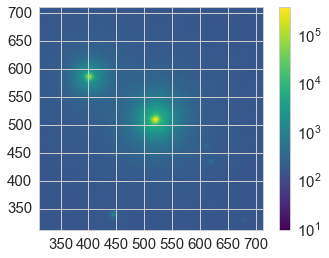

In [3]:
# Plot near the middle
nx, ny = data.shape
width = 200
plt.imshow(data, norm=LogNorm(vmin=10), cmap=viridis)
plt.xlim([nx/2-width, nx/2+width])
plt.ylim([ny/2-width, ny/2+width])
plt.colorbar()

In [4]:
# Get the spatially variable background
bkg = sep.Background(bs_data)

In [16]:
# Subtract the background from the data
bkg_subtracted_data = bs_data - bkg.back()

In [17]:
# Extract the objects. I do this manually for each star, ensuring that I detect everything I can see.
thresh = 3.5 * bkg.globalrms
objects = sep.extract(bkg_subtracted_data, thresh, minarea=10)
kernel = np.array([[1., 2., 3., 2., 1.],
                   [2., 3., 5., 3., 2.],
                   [3., 5., 8., 5., 3.],
                   [2., 3., 5., 3., 2.],
                   [1., 2., 3., 2., 1.]])
#kernel = np.array(((1, 2, 2, 1),
#                   (2, 4, 4, 2),
#                   (2, 4, 4, 2),
#                   (1, 2, 2, 1)))
objects = sep.extract(bkg_subtracted_data, thresh, filter_kernel=kernel)

# Only keep objects if they are near the middle.
nx, ny = bs_data.shape
left, right = nx/2 - width, nx/2 + width
bottom, top = ny/2 - width, ny/2 + width
good = (objects['x'] > left) & (objects['x'] < right) & (objects['y'] > bottom) & (objects['y'] < top)

objects = objects[good]
# objects is a numpy structured array:
len(objects)  # number of objects

4

In [30]:
# Sep could not find the objects for HIP 91118 or HIP 100221 or HIP 22958 or HIP 88116
# Just hard-code the approximate pixel locations and sizes.
x = np.array((445, 520, 401, 610, 617))
y = np.array((339.5, 509, 586.5, 461, 438))
a = np.array((5, 8, 8, 5, 5))
b = a.copy()
theta = np.array((0, 0, 0, 0, 0))

In [19]:
# get the center and ellipse components
x, y = objects['x'], objects['y']
a, b = objects['a'], objects['b']
theta = objects['theta']
print(x, y)
print(a, b)
print(theta)

[ 676.48896302  444.86979857  520.14663638  401.45618484] [ 330.48530629  339.71299545  509.22551623  586.5431124 ]
[  1.53235257   4.24008751  15.27114677  13.2259388 ] [  1.31329954   3.88614702  14.73414707  12.43533039]
[-0.00468099  0.5431971  -1.51839828  1.23592305]


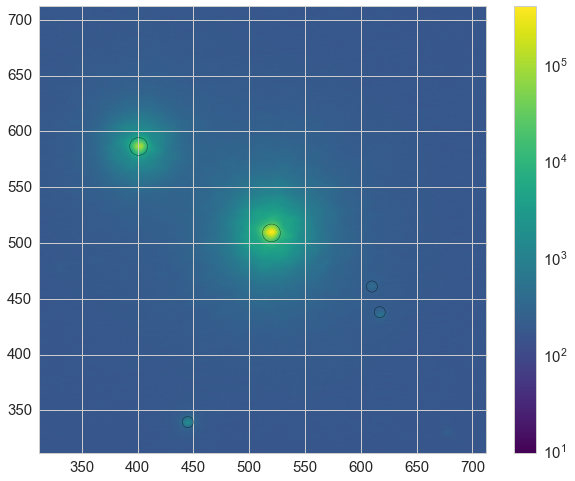

In [31]:
# Plot the ellipses on top of the data
nx, ny = data.shape
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data, norm=LogNorm(vmin=10), cmap=viridis)
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

# Plot the ellipse:
for xi, yi, ai, bi, theta_i in zip(x, y, a, b, theta):
    el = Ellipse(xy=np.array((xi, yi)), width=2*ai, height=2*bi, angle=theta_i*180/np.pi)
    ax.add_artist(el)
    el.set_edgecolor('black')
    el.set_facecolor('none')


In [32]:
# Sum the aperture
flux, fluxerr, flag = sep.sum_ellipse(bkg_subtracted_data, x, y, a, b, theta, 1.0,
                                      subpix=0, err=bkg.rms(), gain=1)
print(flux)
print(fluxerr)

[  4.68421021e+04   1.93362621e+07   5.11272722e+06   8.64975296e+03
   1.15446290e+04]
[  225.43493311  4451.92413847  2313.27606281   238.68739745   167.63620264]


In [33]:
fl = np.random.normal(loc=flux, scale=fluxerr, size=(100000,x.size))
delta_m = 2.5*np.log10(fl[:, 0] / fl[:, 1])
l, m, h = np.percentile(delta_m, [16, 50, 84])
print('Delta K = {:.4f} +{:.5f} / -{:.5f}'.format(m, h-m, m-l))

Delta K = -6.5393 +0.00521 / -0.00522


That is pretty close to the expected value for this star, given the spectral type of the primary (A3V) and the companion temperature ($\sim 5200$ K). Note that I had to *not* use the kron radius that I calculated, and used gain = 1 instead of the header value of 246 to get reasonable errors...

# PSF Photometry
Now, see what answer I get with PSF photometry. I need to use that since some of the companions are very close and blended with the primary star...

In [34]:
from astropy.modeling import models, fitting

In [35]:
# Create a 2D moffat function

@models.custom_model
def Moffat2D(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, x_gamma=6.0, y_gamma=6.0,
             alpha=1.0):
    """Two dimensional Moffat function with different scale parameters for both axes"""
    rr_gg = (x - x_0) ** 2 / x_gamma**2 + (y - y_0) ** 2 / y_gamma ** 2
    return amplitude * (1 + rr_gg) ** (-alpha)


@models.custom_model
def EllipticalMoffat2D(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, 
                       x_gamma=6.0, y_gamma=6.0, theta=0.0,
                       alpha=1.0):
    """Two dimensional elliptical Moffat function with different scale parameters for both axes"""
    A = (np.cos(theta) / x_gamma)**2 + (np.sin(theta) / y_gamma)**2
    B = (np.sin(theta) / x_gamma)**2 + (np.cos(theta / y_gamma))**2
    C = 2 * np.sin(theta) * np.cos(theta) * (1/x_gamma**2 - 1/y_gamma**2)
    rr_gg = A*(x - x_0) ** 2 + B*(y - y_0) ** 2 + C*(x-x_0)*(y-y_0)
    return amplitude * (1 + rr_gg) ** (-alpha)



def Moffat2D_simple(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, x_gamma=6.0, y_gamma=6.0,
             alpha=1.0):
    """Two dimensional Moffat function with different scale parameters for both axes"""
    rr_gg = (x - x_0) ** 2 / x_gamma**2 + (y - y_0) ** 2 / y_gamma ** 2
    return amplitude * (1 + rr_gg) ** (-alpha)

def EllipticalMoffat2D_simple(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, 
                       x_gamma=6.0, y_gamma=6.0, theta=0.0,
                       alpha=1.0):
    """Two dimensional elliptical Moffat function with different scale parameters for both axes"""
    A = (np.cos(theta) / x_gamma)**2 + (np.sin(theta) / y_gamma)**2
    B = (np.sin(theta) / x_gamma)**2 + (np.cos(theta / y_gamma))**2
    C = 2 * np.sin(theta) * np.cos(theta) * (1/x_gamma**2 - 1/y_gamma**2)
    rr_gg = A*(x - x_0) ** 2 + B*(y - y_0) ** 2 + C*(x-x_0)*(y-y_0)
    return amplitude * (1 + rr_gg) ** (-alpha)

In [36]:
def fit_moffat_psf(data, x_mean=512, y_mean=512, x_fwhm=6, y_fwhm=6, multi_stars=False):
    """
    Fit a moffat function to the PSF. A moffat function is given by

    $I_r = I_0 [1+(r/\gamma)^2]^{-\alpha} $

    Where $I_0$ is the intensity at the center of the PSF, $\gamma$ is the
    half-width at half maximum in the absense of atmospheric scattering, and
    $\alpha$ is the atmospheric scattering coefficient.
    
    Parameters:
    ===========
    - data:      np.ndarray with shape(nx, ny)
                 The data to be fit.
                 
    - x_mean:    np.ndarray with shape (N_sources)
                 The initial guesses for the x-position of all of the sources to fit
                 
    - y_mean:    np.ndarray with shape (N_sources)
                 The initial guesses for the y-position of all of the sources to fit
                 
    - x_fwhm:    np.ndarray with shape (N_sources)
                 The initial guesses for the width of all of the sources in the x-direction
                 
    - y_fwhm:    np.ndarray with shape (N_sources)
                 The initial guesses for the width of all of the sources in the y-direction
    """
    # Make sure we have numpy arrays
    x_mean = np.atleast_1d(x_mean)
    y_mean = np.atleast_1d(y_mean)
    x_fwhm = np.atleast_1d(x_fwhm)
    y_fwhm = np.atleast_1d(y_fwhm)
    
    YY, XX = np.indices(data.shape)
    
    # Generate the model to fit
    p_init = models.Const2D(amplitude=0)
    for xi, yi, xwi, ywi in zip(x_mean, y_mean, x_fwhm, y_fwhm):
        p_init += Moffat2D(amplitude=data[np.round(yi).astype(int), np.round(xi).astype(int)],
                           x_0=xi, y_0=yi,
                           x_gamma=xwi, y_gamma=ywi,
                           alpha=1.0)
    
    # Tie the shape parameters together
    p_init.x_gamma_1.tied = lambda mod: mod.x_gamma_2
    p_init.y_gamma_1.tied = lambda mod: mod.y_gamma_2
    p_init.alpha_1.tied = lambda mod: mod.alpha_2
    if multi_stars:
        p_init.x_gamma_3.tied = lambda mod:mod.x_gamma_2
        p_init.y_gamma_3.tied = lambda mod:mod.y_gamma_2
        p_init.alpha_3.tied = lambda mod:mod.alpha_2
        p_init.x_gamma_4.tied = lambda mod:mod.x_gamma_2
        p_init.y_gamma_4.tied = lambda mod:mod.y_gamma_2
        p_init.alpha_4.tied = lambda mod:mod.alpha_2
        p_init.x_gamma_5.tied = lambda mod:mod.x_gamma_2
        p_init.y_gamma_5.tied = lambda mod:mod.y_gamma_2
        p_init.alpha_5.tied = lambda mod:mod.alpha_2

    # Fit the data
    fitter = fitting.LevMarLSQFitter()
    moffat = fitter(p_init, XX, YY, data, maxiter=100000)

    return moffat, fitter




In [45]:
moffat, fitter = fit_moffat_psf(bs_data, x_mean=x, y_mean=y, x_fwhm=a, y_fwhm=b, multi_stars=True)

In [46]:
# Put the parameters in a more reasonable structure
class Parameter(object):
    def __init__(self, name, val, err):
        self.name = name
        self.val = val
        self.err = err
    
    def __repr__(self):
        return '{}: {} +/_ {}'.format(self.name, self.val, self.err)
    
    def __str__(self):
        return '{}: {} +/_ {}'.format(self.name, self.val, self.err)
    
parlist = []
j = 0
cov = fitter.fit_info['param_cov']
for i, (name, value) in enumerate(zip(moffat.param_names, moffat.parameters)):
    if name not in ['x_gamma_1', 'y_gamma_1', 'alpha_1', 
                    'x_gamma_3', 'y_gamma_3', 'alpha_3', 
                    'x_gamma_4', 'y_gamma_4', 'alpha_4', 
                    'x_gamma_5', 'y_gamma_5', 'alpha_5',]:
        parlist.append(Parameter(name=name, val=value, err=np.sqrt(cov[j][j])))
        j += 1

for par in parlist:
    print(par)


amplitude_0: 189.580600696 +/_ 5.62891731325
amplitude_1: 1407.35492015 +/_ 1304.77045554
x_0_1: 444.992806234 +/_ 4.04926880661
y_0_1: 339.460311462 +/_ 3.38964221909
amplitude_2: 431193.932143 +/_ 2492.96408876
x_0_2: 519.338543264 +/_ 0.0132175466674
y_0_2: 509.31392921 +/_ 0.0110651340038
x_gamma_2: 4.21629872121 +/_ 0.0586984588131
y_gamma_2: 3.52950592603 +/_ 0.0491369797567
alpha_2: 1.70493517043 +/_ 0.0240926446735
amplitude_3: 112369.111457 +/_ 1417.26987094
x_0_3: 401.695526819 +/_ 0.0507143127279
y_0_3: 585.973774303 +/_ 0.0424573768172
amplitude_4: 420.839023141 +/_ 1304.82745022
x_0_4: 617.165116041 +/_ 13.5424959478
y_0_4: 435.525227845 +/_ 11.3362827805
amplitude_5: 335.732769044 +/_ 1304.83026995
x_0_5: 609.333831633 +/_ 16.9882983939
y_0_5: 461.195734645 +/_ 14.220948102


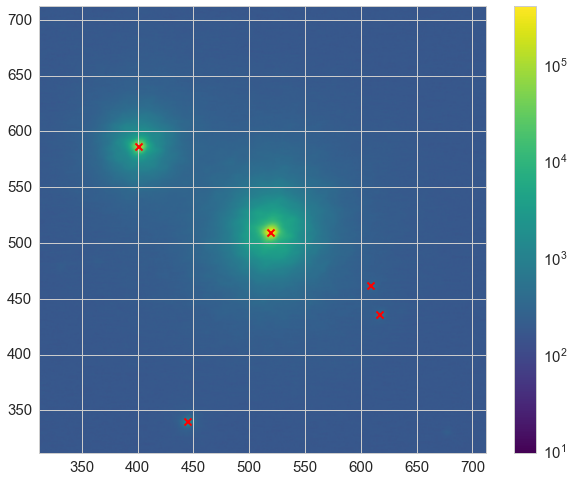

In [47]:
# Plot the fitted centroids
nx, ny = data.shape
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data, norm=LogNorm(vmin=10), cmap=viridis)
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

x_centroid = np.array((moffat.x_0_1.value, moffat.x_0_2.value))
y_centroid = np.array((moffat.y_0_1.value, moffat.y_0_2.value))
x_centroid = np.array((moffat.x_0_1.value, moffat.x_0_2.value, moffat.x_0_3.value, moffat.x_0_4.value, moffat.x_0_5.value))
y_centroid = np.array((moffat.y_0_1.value, moffat.y_0_2.value, moffat.y_0_3.value, moffat.y_0_4.value, moffat.y_0_5.value))
#x_centroid = np.array((gauss.x_mean_1.value, gauss.x_mean_2.value))
#y_centroid = np.array((gauss.y_mean_1.value, gauss.y_mean_2.value))
#x_centroid = np.array((p_init.x_0_1.value, p_init.x_0_2.value))
#y_centroid = np.array((p_init.y_0_1.value, p_init.y_0_2.value))
ax.scatter(x_centroid, y_centroid, marker='x', s=50, c='red', linewidths=2)

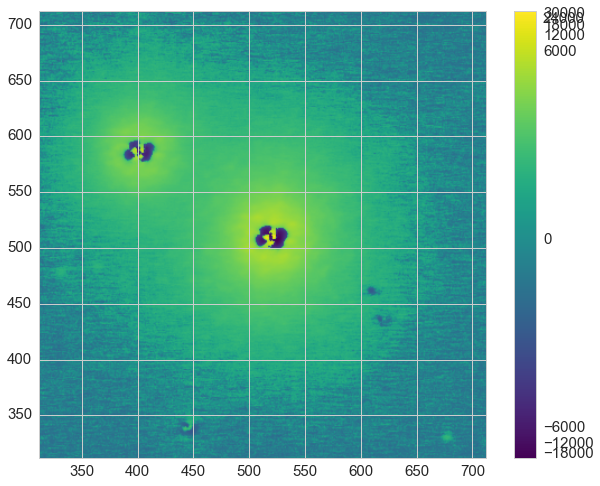

In [48]:
# Plot the residuals
nx, ny = data.shape

YY, XX = np.indices(bs_data.shape)
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data - moffat(XX, YY), cmap=viridis, norm=SymLogNorm(linthresh=10))
#im = ax.imshow(moffat(XX, YY), cmap=viridis, norm=SymLogNorm(linthresh=10))
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

In [95]:
from scipy.integrate import dblquad

In [96]:
def calculate_integral(moffat_fcn, nstd=10):
    left_bound = max(moffat_fcn.x_0 - nstd*moffat_fcn.x_gamma, 0)
    right_bound = min(1024, moffat_fcn.x_0 + nstd*moffat_fcn.x_gamma)
    lower_bound = max(moffat_fcn.y_0 - nstd*moffat_fcn.y_gamma, 0)
    upper_bound = min(1024, moffat_fcn.y_0 + nstd*moffat_fcn.y_gamma)
    
    result = dblquad(moffat_fcn, a=left_bound, b=right_bound,
                     gfun=lambda x: lower_bound,
                     hfun=lambda y: upper_bound)
    return result


def integrate(moffat_fcn, nstd=10):
    """ Integrate both moffat functions independently
    """
    
    moffat1 = Moffat2D(amplitude=moffat_fcn.amplitude_1,
                       x_0=moffat_fcn.x_0_1,
                       y_0=moffat_fcn.y_0_1,
                       x_gamma=moffat_fcn.x_gamma_1,
                       y_gamma=moffat_fcn.y_gamma_1,
                       alpha=moffat_fcn.alpha_1)
    
    moffat2 = Moffat2D(amplitude=moffat_fcn.amplitude_2,
                       x_0=moffat_fcn.x_0_2,
                       y_0=moffat_fcn.y_0_2,
                       x_gamma=moffat_fcn.x_gamma_2,
                       y_gamma=moffat_fcn.y_gamma_2,
                       alpha=moffat_fcn.alpha_2)
    
    result1 = calculate_integral(moffat1, nstd=nstd)
    result2 = calculate_integral(moffat2, nstd=nstd)
    return result1, result2


def calculate_integral_simple(pars):
    amplitude, x0, y0, x_gamma, y_gamma, alpha, nstd = pars
    left_bound = max(x0 - nstd*x_gamma, 0)
    right_bound = min(1024, x0 + nstd*x_gamma)
    lower_bound = max(y0 - nstd*y_gamma, 0)
    upper_bound = min(1024, y0 + nstd*y_gamma)
    
    result = dblquad(Moffat2D_simple, a=left_bound, b=right_bound,
                     gfun=lambda x: lower_bound,
                     hfun=lambda y: upper_bound, args=(amplitude, x0, y0, x_gamma, y_gamma, alpha))
    return result


def make_moffat_iterable(amplitude, x0, y0, xgamma, ygamma, alpha, N=100, nstd=20):
    """
    Make a bunch of moffat functions that sample the uncertainties in the fitted parameters
    """
    amp = np.random.normal(loc=amplitude.val, scale=amplitude.err, size=N)
    x_0 = np.random.normal(loc=x0.val, scale=x0.err, size=N)
    y_0 = np.random.normal(loc=y0.val, scale=y0.err, size=N)
    x_gamma = np.random.normal(loc=xgamma.val, scale=xgamma.err, size=N)
    y_gamma = np.random.normal(loc=ygamma.val, scale=ygamma.err, size=N)
    alpha = np.random.normal(loc=alpha.val, scale=alpha.err, size=N)
    for i in range(N):
        #moffat = Moffat2D(amplitude=amp[i],
        #                  x_0=x_0[i], y_0=y_0[i],
        #                  x_gamma=x_gamma[i], y_gamma=y_gamma[i],
        #                  alpha=alpha[i])
        #yield moffat
        #yield moffat.amplitude.value, moffat.x_0.value, moffat.y_0.value, moffat.x_gamma.value, moffat.y_gamma.value, moffat.alpha.value, nstd
        yield amp[i], x_0[i], y_0[i], x_gamma[i], y_gamma[i], alpha[i], nstd

In [97]:
import multiprocessing

In [98]:
p = multiprocessing.Pool(processes=8)

# Sample with the full covariance matrix

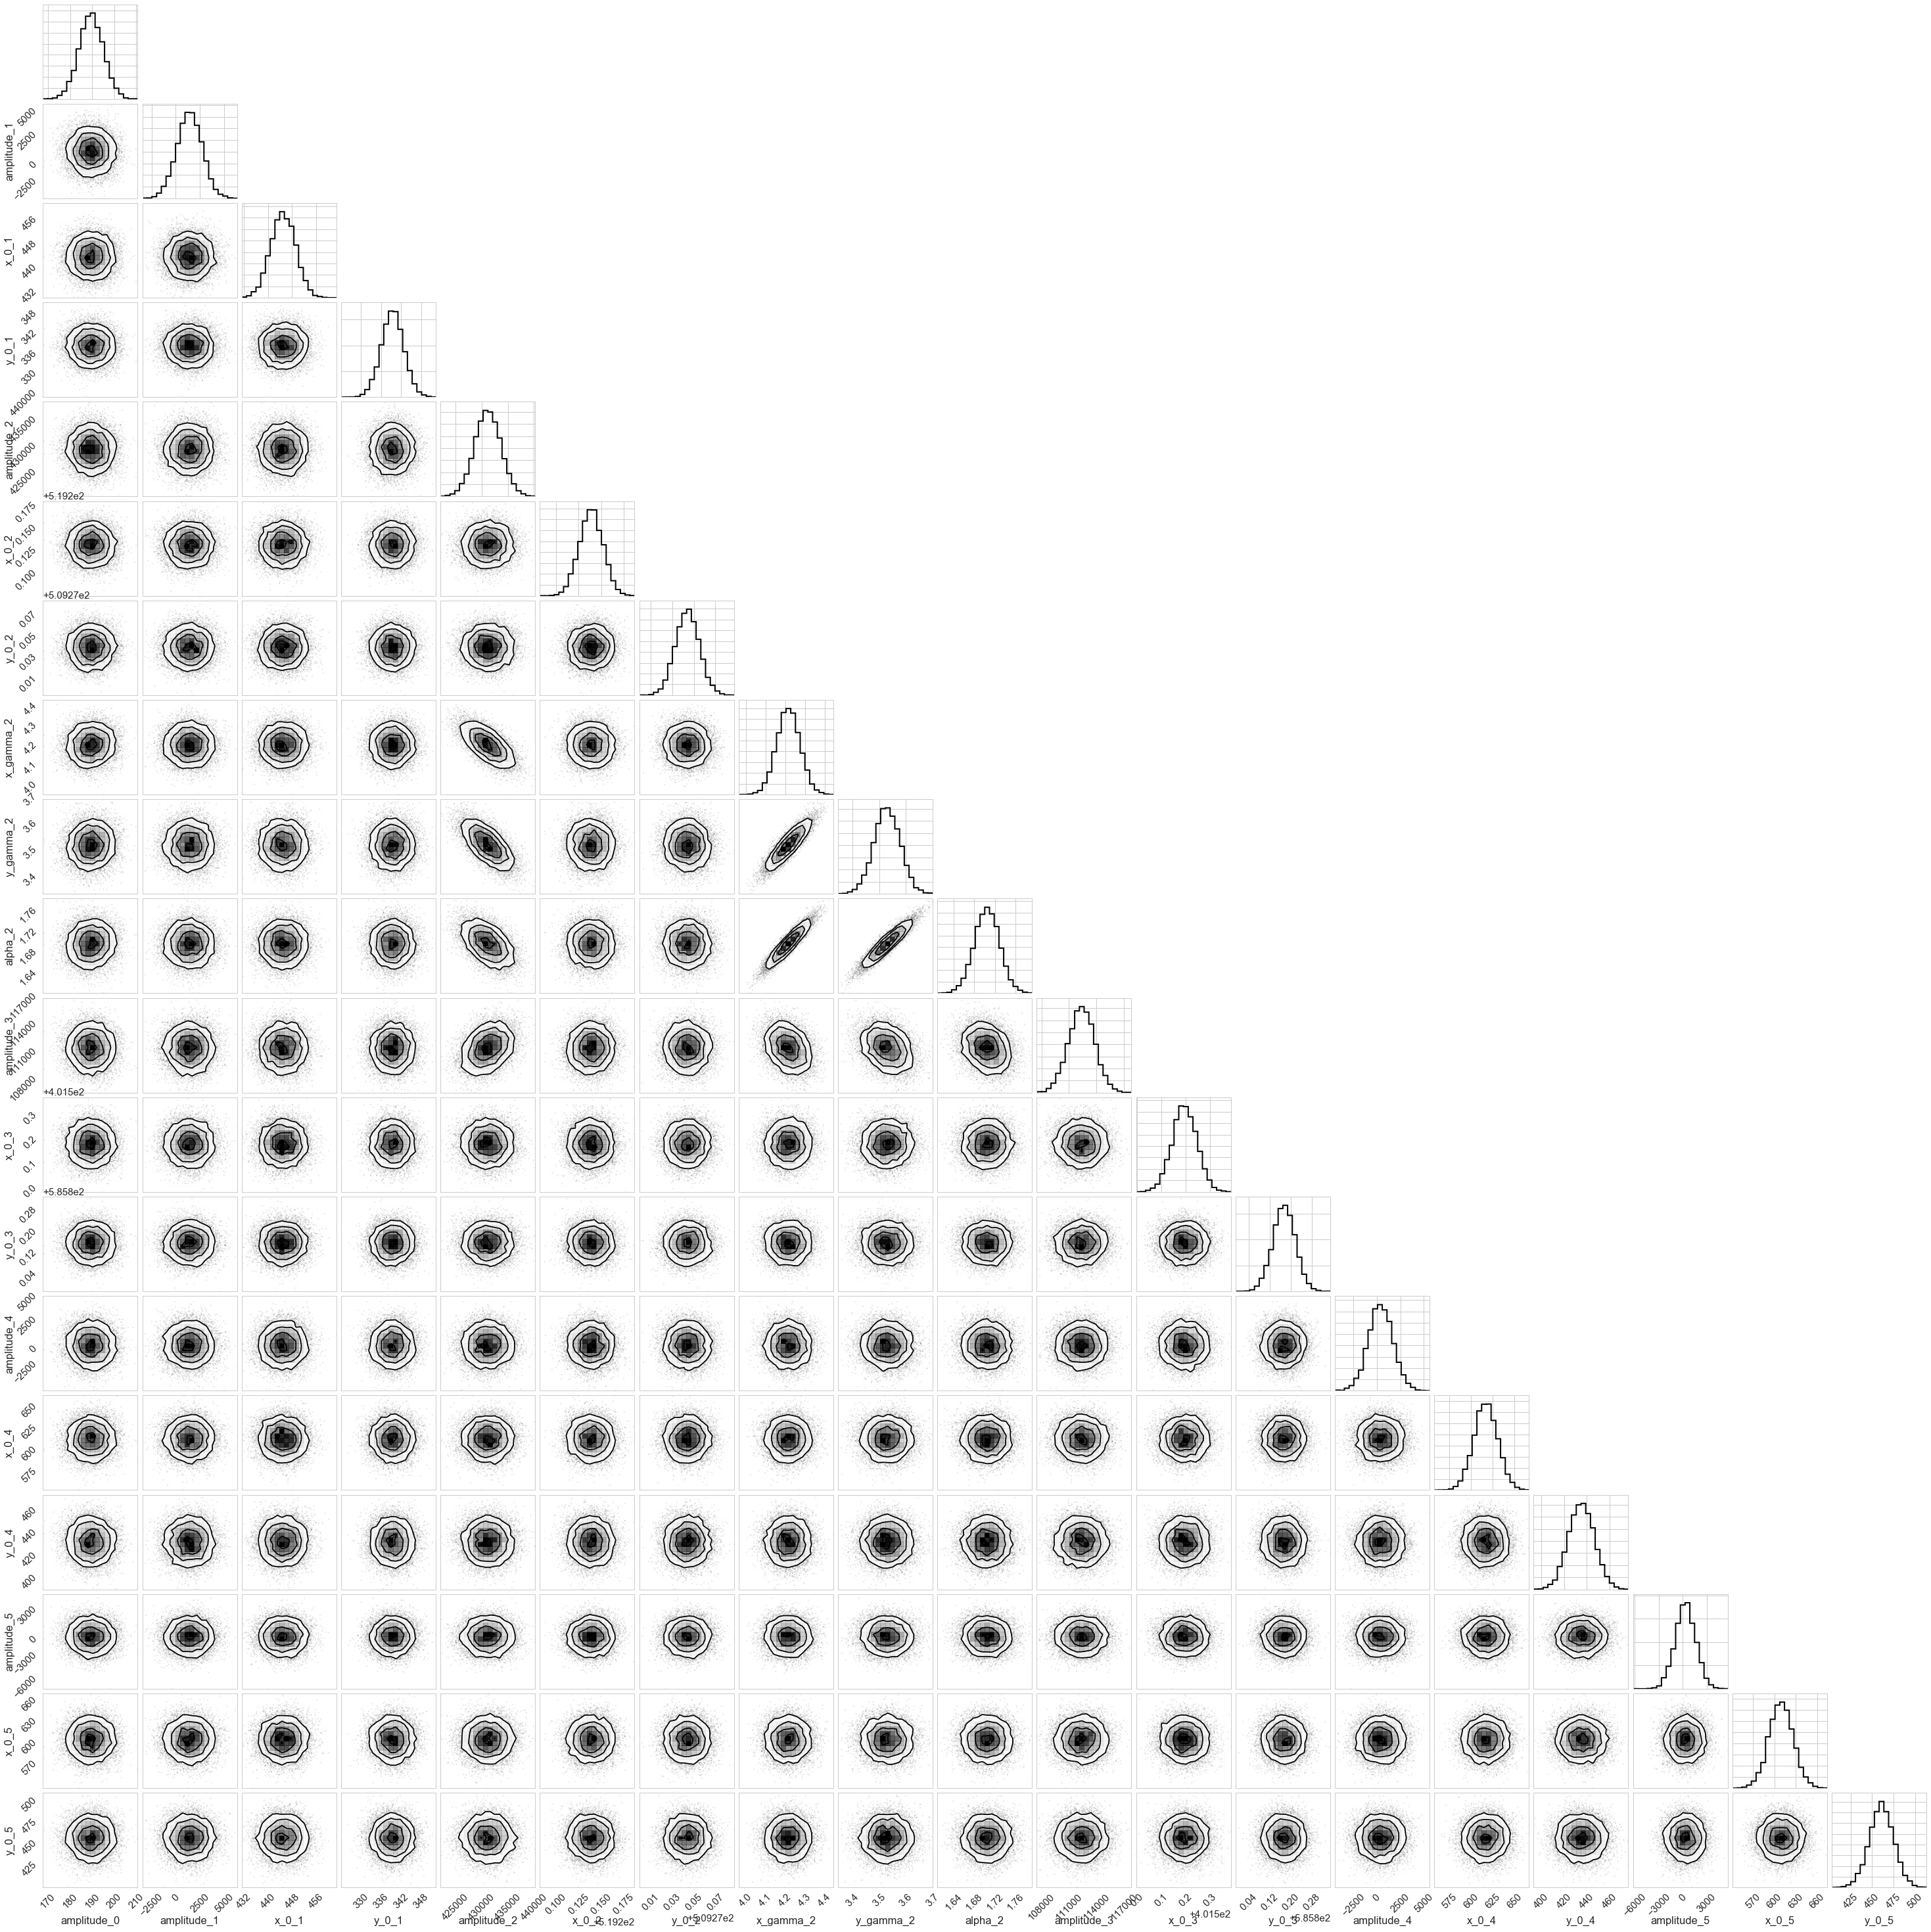

In [172]:

import pandas as pd
from scipy import stats
import corner

best_pars = []
names = []
for val, name in zip(moffat.parameters, moffat.param_names):
    if name not in ['x_gamma_1', 'y_gamma_1', 'alpha_1', 
                    'x_gamma_3', 'y_gamma_3', 'alpha_3',
                    'x_gamma_4', 'y_gamma_4', 'alpha_4',
                    'x_gamma_5', 'y_gamma_5', 'alpha_5']:
        best_pars.append(val)
        names.append(name)

samples = stats.multivariate_normal.rvs(mean=best_pars, cov=cov, size=10000)
fig = corner.corner(samples, labels=names, hist_kwargs=dict(lw=2))

sample_df = pd.DataFrame(data=samples, columns=names)
sample_df['x_gamma_1'] = sample_df.x_gamma_2.copy()
sample_df['y_gamma_1'] = sample_df.y_gamma_2.copy()
sample_df['alpha_1'] = sample_df.alpha_2.copy()
sample_df['x_gamma_3'] = sample_df.x_gamma_2.copy()
sample_df['y_gamma_3'] = sample_df.y_gamma_2.copy()
sample_df['alpha_3'] = sample_df.alpha_2.copy()
sample_df['x_gamma_4'] = sample_df.x_gamma_2.copy()
sample_df['y_gamma_4'] = sample_df.y_gamma_2.copy()
sample_df['alpha_4'] = sample_df.alpha_2.copy()
sample_df['x_gamma_5'] = sample_df.x_gamma_2.copy()
sample_df['y_gamma_5'] = sample_df.y_gamma_2.copy()
sample_df['alpha_5'] = sample_df.alpha_2.copy()

In [173]:
def make_iterable(df, cols, nstd=20):
    N = df.shape[0]
    for i in range(N):
        row = list(df.loc[i, cols].values)
        row.append(nstd)
        yield row

I1 = make_iterable(sample_df, ['amplitude_1', 'x_0_1', 'y_0_1', 'x_gamma_1', 'y_gamma_1', 'alpha_1'], nstd=50)
result_1 = p.map(calculate_integral_simple, I1)

I2 = make_iterable(sample_df, ['amplitude_2', 'x_0_2', 'y_0_2', 'x_gamma_2', 'y_gamma_2', 'alpha_2'], nstd=50)
result_2 = p.map(calculate_integral_simple, I2)

I3 = make_iterable(sample_df, ['amplitude_3', 'x_0_3', 'y_0_3', 'x_gamma_3', 'y_gamma_3', 'alpha_3'], nstd=50)
result_3 = p.map(calculate_integral_simple, I3)

I4 = make_iterable(sample_df, ['amplitude_4', 'x_0_4', 'y_0_4', 'x_gamma_4', 'y_gamma_4', 'alpha_4'], nstd=50)
result_4 = p.map(calculate_integral_simple, I4)

I5 = make_iterable(sample_df, ['amplitude_5', 'x_0_5', 'y_0_5', 'x_gamma_5', 'y_gamma_5', 'alpha_5'], nstd=50)
result_5 = p.map(calculate_integral_simple, I5)

AttributeError: max must be larger than min in range parameter.

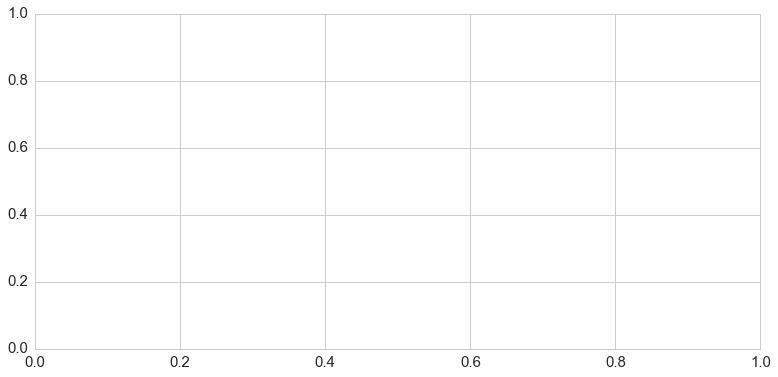

In [174]:
flux1 = np.array([r[0] for r in result_1])
flux2 = np.array([r[0] for r in result_2])
flux3 = np.array([r[0] for r in result_3])
flux4 = np.array([r[0] for r in result_4])
flux5 = np.array([r[0] for r in result_5])
#flux3 = np.array([r[0] for r in result_3])
delta_m = 2.5 * np.log10(flux1/flux2)

fig, ax = plt.subplots(1, 1, figsize=(13,6))
ax.hist(delta_m, normed=True)
ax.set_xlabel(r'$\Delta$ K')
ax.set_ylabel(r'$P(\Delta \rm K)$')
print('Delta K_c = {:.2f} +/- {:.2f}'.format(np.mean(delta_m), np.std(delta_m)))

In [177]:
sample_df['flux1'] = flux1
sample_df['flux2'] = flux2
sample_df['flux3'] = flux3
sample_df['flux4'] = flux4
sample_df['flux5'] = flux5

sample_df['delta_m'] = 2.5*np.log10(flux1/flux2)

In [9]:
from astropy import wcs
from astropy import units as u

header = fits.getheader(filename, 1)
w = wcs.WCS(header)

In [11]:
sample_df.delta_m = 2.5*np.log10(sample_df.flux3 / sample_df.flux2)

In [12]:
#lat1, lon1 = w.all_pix2world(sample_df.x_0_1, sample_df.y_0_1, 0)
#lat2, lon2 = w.all_pix2world(sample_df.x_0_2, sample_df.y_0_2, 0)
lat1, lon1 = w.all_pix2world(sample_df.x_0_2, sample_df.y_0_2, 0)
lat2, lon2 = w.all_pix2world(sample_df.x_0_3, sample_df.y_0_3, 0)

sample_df['rho'] = np.sqrt((lat1-lat2)**2 + (lon1-lon2)**2) * u.degree.to(u.arcsecond)
sample_df['theta'] = np.arctan2(lat2-lat1, lon2-lon1) * u.radian.to(u.degree)
sample_df[['rho', 'theta', 'delta_m']].describe()

,rho,theta,delta_m
count,10000.000000,10000.000000,10000.000000
mean,3.259763,59.287885,-3.936019
std,0.001187,0.018506,0.429846
min,3.255510,59.213398,-5.071859
25%,3.258960,59.275305,-4.241490
50%,3.259780,59.287718,-3.984543
75%,3.260564,59.300301,-3.679749
max,3.264205,59.354993,-2.049967


# Save the Monte Carlo samples.

In [180]:
import os
outfilename = 'data/Imaging/{}.csv'.format(os.path.basename(filename).split('.')[0])
sample_df.to_csv(outfilename, index=False)